# Entanglement by measurement on Starmon-5 -- Analysis

In [23]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import itertools as it

import qiskit.tools.jupyter
import qiskit.tools.visualization as qvis # circuit_drawer, plot_histogram

from importlib import reload
import inspire_experiments
reload(inspire_experiments)
from inspire_experiments import ExperimentData, get_starmon_status, inspire_login, get_file_header, measure_readout_correction
from inspire_experiments.analysis_tools import *

# matplotlib.style.use('ggplot')
# matplotlib.style.use('seaborn')
# %matplotlib notebook
%load_ext autoreload
%autoreload 2
%qiskit_version_table

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
api, backend = inspire_login()
backend.status()

Backend status:  OFFLINE


In [3]:

get_starmon_status(api)


'OFFLINE'

## Entaglement by msmt


### Readout correction

In [4]:
# qubits = [1, 2, 3]
# tomo_qubits = [1, 3]
# qubits = [0, 2, 4]
# tomo_qubits = [0, 4]
# qubits = [1, 2, 4]
# tomo_qubits = [1, 4]
# qubits = [0, 2, 3]
# tomo_qubits = [0, 3]
qubits = [0, 2, 1]
tomo_qubits = [0, 1]
exp_name = "entanglement_by_msmt_qbs"
sim_msmt = False
dd_sequence = 'XY4'
# extra_label = "_Xqb0"
extra_label = "_wait50AfterInit"


exp_name += str(qubits)
exp_name += "_sim-msmt" if sim_msmt else ''
# exp_name += "_XY4" if not sim_msmt else ''
exp_name += f"_{dd_sequence}" if dd_sequence and not sim_msmt else ''
exp_name += extra_label if extra_label else ''
exp_name += f"_tom{tomo_qubits}"
# exp_name = exp_name + "_sim-msmt" if sim_msmt else exp_name
print(exp_name)

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]


In [5]:
shots_dict = {qb: {} for qb in tomo_qubits}
for state in [''.join(s) for s in it.product(['0', '1'], repeat=2)]:
    print(state)
    bitstrings = ExperimentData.get_csv_data(f"readout_correction_qbs{tomo_qubits}_state{state}_RAW.csv", use_string_repr=True)
    pprint(bitstrings)
    for qb in shots_dict.keys():
        shots_dict[qb][state] = 1 - 2*np.array(list(map(lambda s: s[-1-qb], bitstrings)), dtype=int)
shots_dict

00
array(['00000', '00000', '00000', ..., '00000', '00000', '00000'],
      dtype='<U5')
01
array(['00010', '00010', '00010', ..., '00010', '00010', '00010'],
      dtype='<U5')
10
array(['00001', '00001', '00011', ..., '00001', '00001', '00001'],
      dtype='<U5')
11
array(['00011', '00011', '00011', ..., '00011', '00011', '00011'],
      dtype='<U5')


{0: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([1, 1, 1, ..., 1, 1, 1]),
  '10': array([-1, -1, -1, ..., -1, -1, -1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])},
 1: {'00': array([1, 1, 1, ..., 1, 1, 1]),
  '01': array([-1, -1, -1, ..., -1, -1, -1]),
  '10': array([ 1,  1, -1, ...,  1,  1,  1]),
  '11': array([-1, -1, -1, ..., -1, -1, -1])}}

In [6]:
(shots_dict[tomo_qubits[0]]['11'] == shots_dict[tomo_qubits[1]]['11']).all()

False

In [7]:
beta = get_beta_matrix(shots_dict, 2)
beta

{'IZ': array([ 1.91955566e-02,  9.55780029e-01,  1.67846680e-03, -9.46044922e-04]),
 'ZI': array([ 3.17993164e-02,  1.89208984e-03,  9.37561035e-01, -5.49316406e-04]),
 'ZZ': array([0.00338745, 0.02871704, 0.01773071, 0.89730835])}

### Tomography data

In [8]:
print(gen_gate_order(2))

['ZZ' 'XZ' 'YZ' 'ZX' 'XX' 'YX' 'ZY' 'XY' 'YY']


In [9]:
# masks_0 = np.empty((len(gen_gate_order(2)), 2**14))
# masks_1 = np.empty((len(gen_gate_order(2)), 2**14))
gate_order = gen_gate_order(2)
masks_0 = [None] * len(gate_order)
masks_1 = [None] * len(gate_order)

tomo_shots_dict = {qb: {} for qb in tomo_qubits}

for i, tomo_state in enumerate(gate_order):
    # print(tomo_state)
    filename = exp_name + f"_M{tuple(tomo_state)}"
    print(filename)
    bitstrings = ExperimentData.get_csv_data(filename + "_RAW.csv", use_string_repr=False)
    print(bitstrings)
    if sim_msmt:
        # for simultaneous msmt
        mask_bits = bitstrings
        tomo_bits = bitstrings
    else:
        # for sequential msmt
        mask_bits = bitstrings[0]
        tomo_bits = bitstrings[1]

    # create masks for postselection on state of middle (ancilla) qubit
    masks_0[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 0, 1, np.nan)
    masks_1[i] = np.where(np.array(list(map(lambda s: int(s[qubits[1]]), mask_bits))) == 1, 1, np.nan)

    # create dict for shots by qubit, per tomo_state
    for qb in shots_dict.keys():
        tomo_shots_dict[qb][tomo_state] = 1 - 2*np.array(list(map(lambda s: int(s[-1-qb]), tomo_bits)))

tomo_shots_dict

entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Z', 'Z')
[[[0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 0 0 0 0]
  [0 0 0 1 0]
  [0 0 0 0 0]
  ...
  [0 0 0 1 1]
  [0 0 0 1 1]
  [0 0 0 0 0]]]
entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('X', 'Z')
[[[0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  ...
  [0 0 1 0 0]
  [0 0 1 0 0]
  [0 0 1 0 0]]

 [[0 0 0 0 0]
  [0 0 0 0 1]
  [0 0 0 0 0]
  ...
  [0 0 0 1 0]
  [0 0 0 1 0]
  [0 0 0 0 0]]]
entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Y', 'Z')
[[[0 0 1 0 0]
  [0 0 1 0 0]
  [0 0 0 0 0]
  ...
  [0 0 1 0 0]
  [0 0 0 0 0]
  [0 0 1 0 0]]

 [[0 0 0 0 1]
  [0 0 0 1 0]
  [0 0 0 0 0]
  ...
  [0 0 0 1 1]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_M('Z', 'X')
[[[0 0 1 0 0]
  [0 0 1 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 0]
  [0 0 1 0 0]
  [0 0 1 0 0]]

 [[0 0 0 1 0]
  [0 0 0 1 1]
  [0 0 0 0 0]
  ...
  [0

{0: {'ZZ': array([ 1,  1,  1, ..., -1, -1,  1]),
  'XZ': array([ 1, -1,  1, ...,  1,  1,  1]),
  'YZ': array([-1,  1,  1, ..., -1,  1,  1]),
  'ZX': array([ 1, -1,  1, ...,  1,  1, -1]),
  'XX': array([-1, -1,  1, ...,  1,  1, -1]),
  'YX': array([-1, -1, -1, ..., -1, -1, -1]),
  'ZY': array([ 1, -1,  1, ..., -1, -1, -1]),
  'XY': array([-1, -1,  1, ...,  1, -1, -1]),
  'YY': array([ 1, -1,  1, ...,  1, -1, -1])},
 1: {'ZZ': array([ 1, -1,  1, ..., -1, -1,  1]),
  'XZ': array([ 1,  1,  1, ..., -1, -1,  1]),
  'YZ': array([ 1, -1,  1, ..., -1,  1,  1]),
  'ZX': array([-1, -1,  1, ..., -1, -1, -1]),
  'XX': array([-1, -1,  1, ..., -1,  1, -1]),
  'YX': array([ 1,  1,  1, ..., -1,  1,  1]),
  'ZY': array([ 1, -1,  1, ...,  1,  1,  1]),
  'XY': array([ 1, -1, -1, ..., -1, -1,  1]),
  'YY': array([-1,  1,  1, ..., -1, -1, -1])}}

In [10]:
ExperimentData.timestamp


'Tue Aug 30 17:36:51 2022'

### Results

In [11]:
expvals_0, rho_0, p_frac0 = get_pauli_expectation_values(tomo_shots_dict, beta, gate_order, masks_0)
expvals_1, rho_1, p_frac1 = get_pauli_expectation_values(tomo_shots_dict, beta, gate_order, masks_1)

#### Check physicality of resulting density matrix

In [133]:
np.abs(rho_1)

array([[0.39320945, 0.033333  , 0.03727281, 0.36461607],
       [0.033333  , 0.09230511, 0.00585847, 0.05223714],
       [0.03727281, 0.00585847, 0.082944  , 0.04889539],
       [0.36461607, 0.05223714, 0.04889539, 0.43154144]])

In [42]:
np.allclose(list(map(np.trace, [rho_1, rho_0])), 1.0)

True

In [43]:
np.abs(rho_1) <= 0.5

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [44]:
np.mean(list(p_frac1.values()))

0.4919166564941406

### Plotting

In [12]:
zero = np.array([1,0])
one = np.array([0,1])
A = np.kron(zero, zero)
B = np.kron(one, one)
# A = np.kron(zero, one)
# B = np.kron(one, zero)
# A = np.kron(one, one)
# B = np.kron(one, one)
# np.trace(np.outer(A, B)**2)
# rho = np.outer(A, B)
rho = np.outer((A+B)/np.sqrt(2), (A+B)/np.sqrt(2))
# np.trace(rho)
rho


array([[0.5, 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0.5]])

20:09:58 - inspire_experiments.data_utils:INFO - Saving figure <entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1] - Figure(1800x1600)> in ./plots/


0.7770134997307404 0.7600388305933204


/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
/media/redwombat/DataNVME/Sciebo/Uni/TUDELFT/QuantumInspire/Starmon-5/src/inspire-experiments/inspire_experiments/data_utils.py:143: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(directory / Path(name + "_PLOT.png"), format='png', dpi=200)
20:09:59 - inspire_experiments.data_utils:INFO - Saving figure <entanglement_by_msmt_qbs[0, 2, 1]_XY4_wait50AfterInit_tom[0, 1]_EXPVALS - Figure(1260x720)> in ./plots/


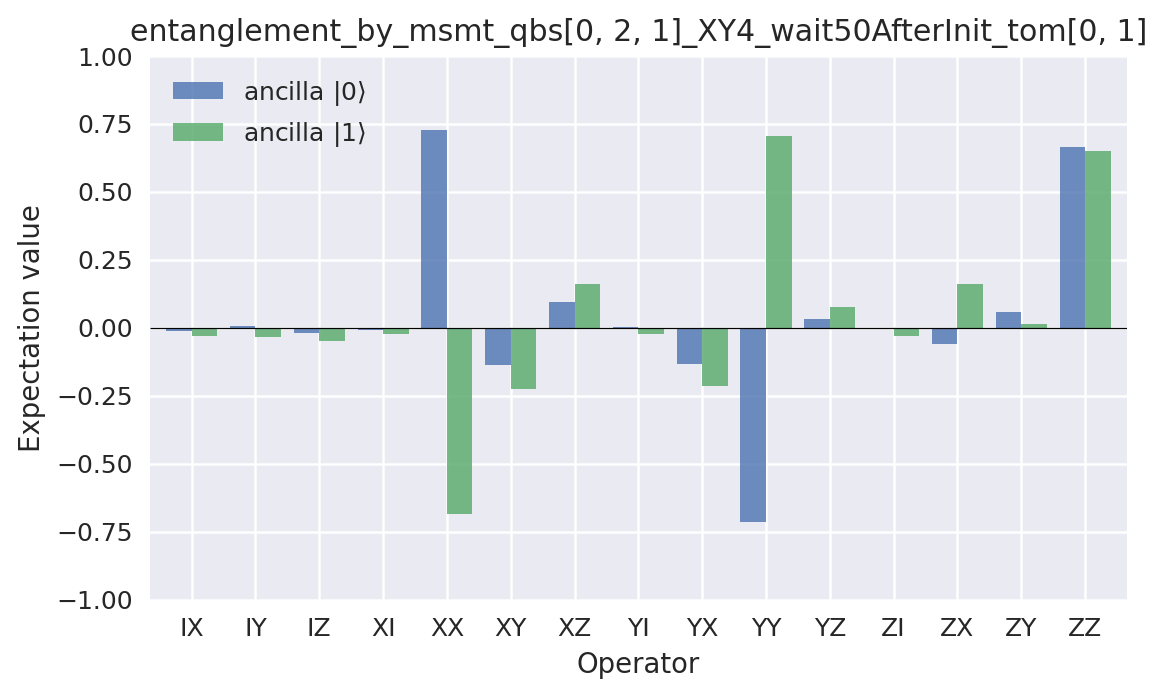

/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/redwombat/miniconda3/envs/sci_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


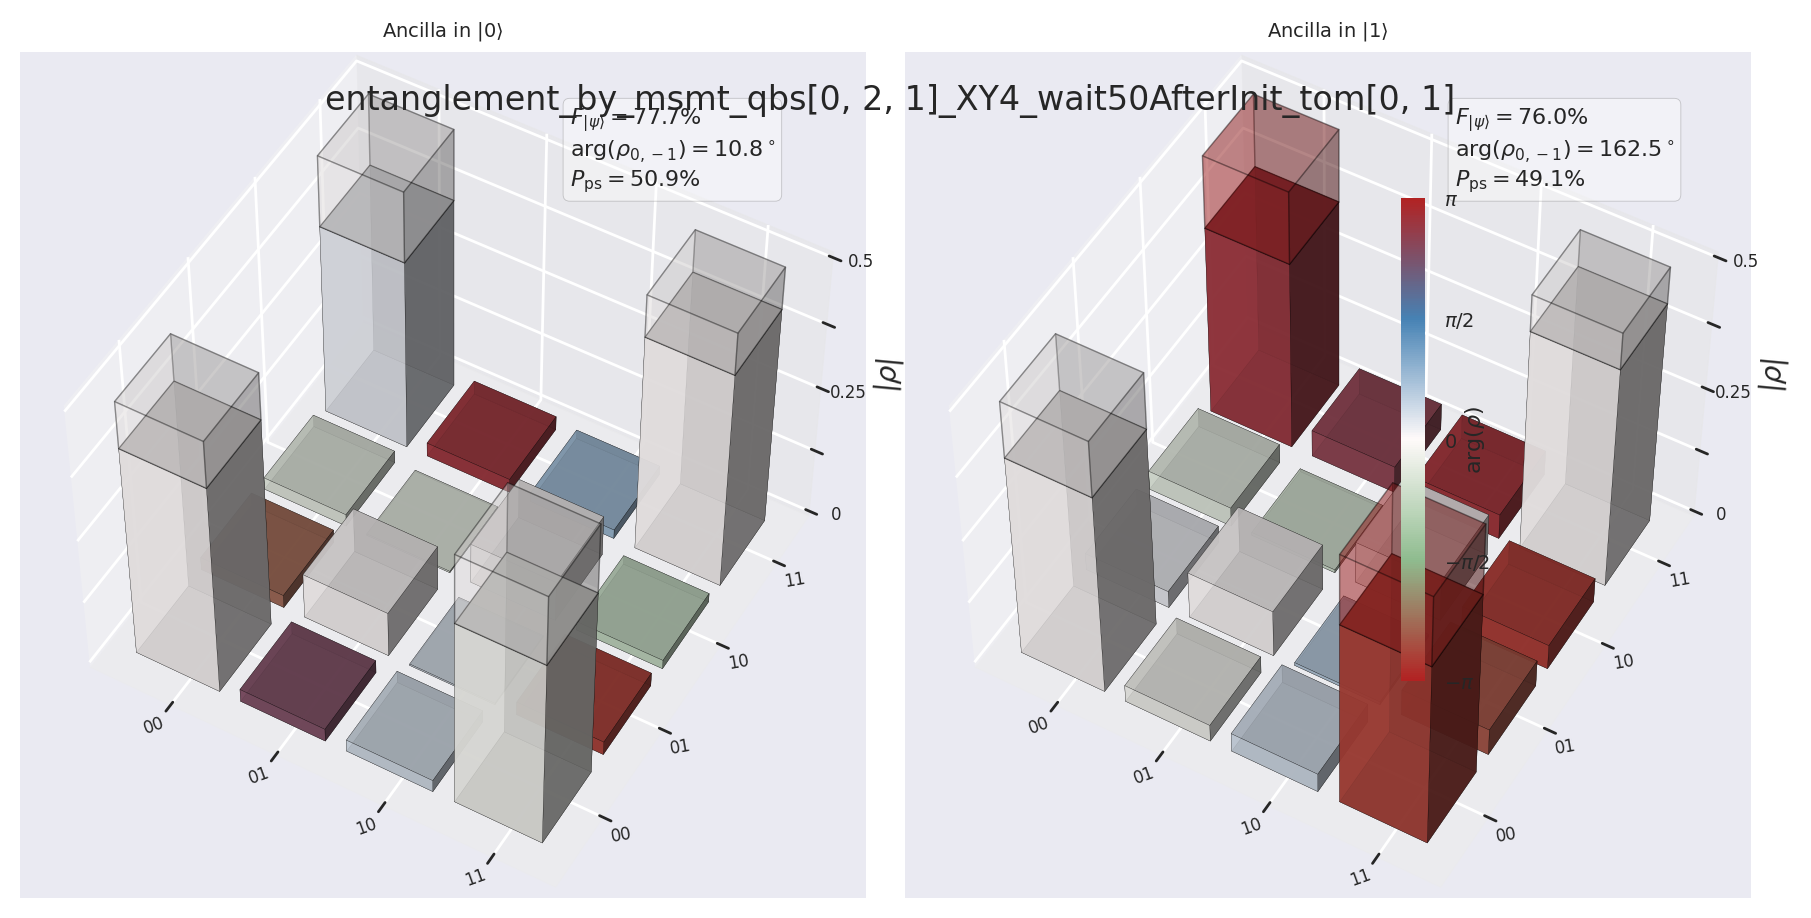

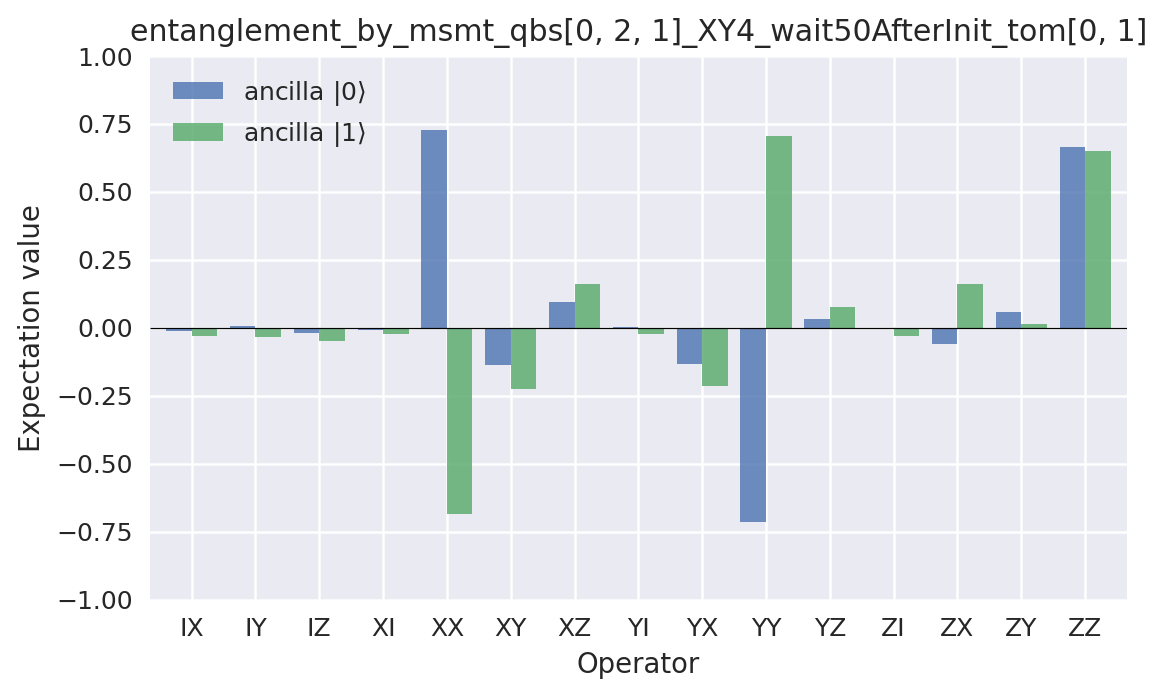

In [25]:
# rho_model_0 = np.zeros(rho_0.shape)
# rho_model_0[ 0, 0] = 0.5
# rho_model_0[ 0,-1] = 0.5
# rho_model_0[-1, 0] = 0.5
# rho_model_0[-1,-1] = 0.5

rho_model_0 = np.outer((A+B)/np.sqrt(2), (A+B)/np.sqrt(2))
rho_model_1 = np.outer((A-B)/np.sqrt(2), (A-B)/np.sqrt(2))

fid_0 = fidelity(rho_0, rho_model_0)
fid_1 = fidelity(rho_1, rho_model_1)
angle_0 = np.angle(rho_0[0,-1], deg=True)
angle_1 = np.angle(rho_1[0,-1], deg=True)
print(fid_0, fid_1)

fig = plot_density_matrix(rho=rho_0, rho_id=rho_model_0, angle=angle_0, fidelity=fid_0, ps_frac=np.mean(list(p_frac0.values())), title=r"Ancilla in $\vert 0 \rangle$",
  rho2=rho_1, rho2_id=rho_model_1, angle2=angle_1, fidelity2=fid_1, ps_frac2=np.mean(list(p_frac1.values())), title2=r"Ancilla in $\vert 1 \rangle$",
                          camera_azim=-60, camera_elev=50)
fig.suptitle(exp_name, y=0.725)
ExperimentData.save_fig(fig, exp_name)

df = pd.DataFrame({r'ancilla $|0\rangle$': expvals_0, r'ancilla $|1\rangle$': expvals_1}).sort_index()
fig2, _ = plot_pauli_exp_values(df[1:], title=exp_name)
ExperimentData.save_fig(fig2, exp_name + "_EXPVALS")

In [59]:
df

,ancilla $|0\rangle$,ancilla $|1\rangle$
II,1.000000,1.000000
IX,0.126815,0.171036
IY,0.137407,0.182703
IZ,0.147536,0.176699
XI,0.030347,0.046834
XX,0.486204,0.266391
XY,0.248895,-0.278161
XZ,-0.042944,0.039356
YI,0.017286,0.002440
YX,0.277601,-0.293088


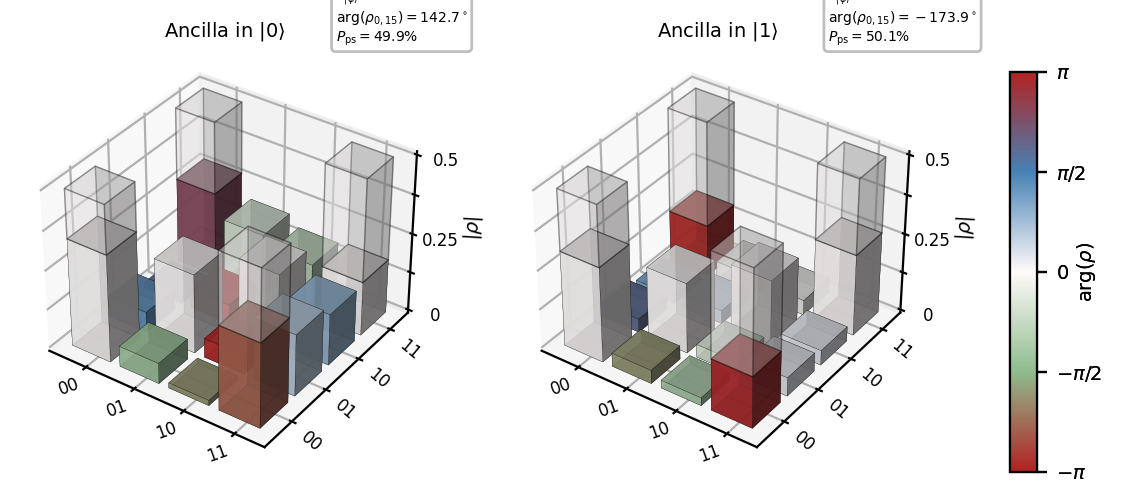

In [57]:
fig = plt.figure(figsize=(9, 8), dpi = 200)
# fig.subplots_adjust(0,0,1,1)
ax = fig.add_subplot(131, projection='3d', azim=-55, elev=35)
ax2 = fig.add_subplot(132, projection='3d', azim=-55, elev=35)
plot_density_matrix(rho_0, ax, rho_id=R_0, title=r"Ancilla in $\vert 0 \rangle$", fidelity=fid_0, ps_frac=ps_frac_0, angle=angle_0)
plot_density_matrix(rho_1, ax2, rho_id=R_0, title=r"Ancilla in $\vert 1 \rangle$", fidelity=fid_1, ps_frac=ps_frac_1, angle=angle_1)
filename = exp_name + "_sim-msmt" + "_PLOT.png" if sim_msmt else exp_name + "_PLOT.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

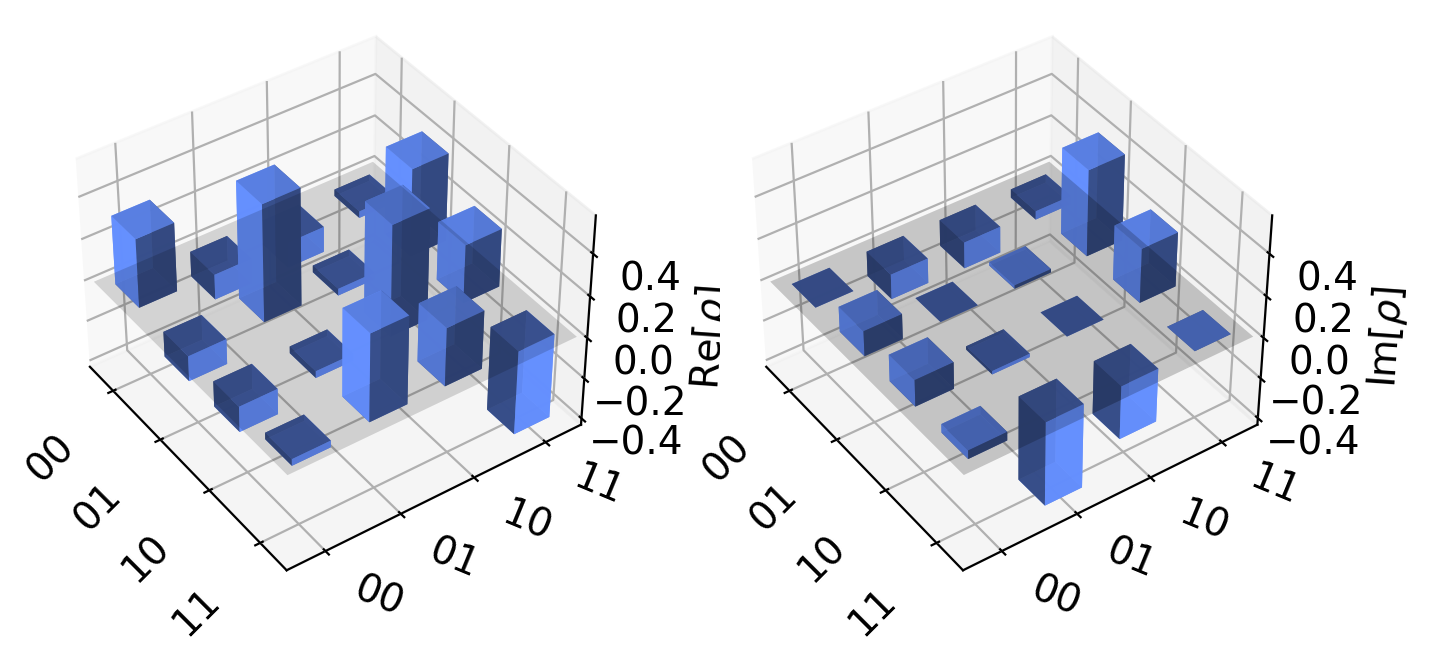

In [69]:
fig = plt.figure(figsize=(8, 8), dpi=200)
ax1 = fig.add_subplot(121, projection='3d', azim=-35, elev=40)
ax2 = fig.add_subplot(122, projection='3d', azim=-35, elev=40)
qvis.plot_state_city(rho_0, alpha=0.9, ax_real=ax1, ax_imag=ax2)
filename = exp_name + "_sim-msmt" + "_PLOT2.png" if sim_msmt else exp_name + "_PLOT2.png"
fig.savefig(DATA_DIR + filename, format='png', dpi=200)

# Testing

In [75]:
qubits = [1,2,3]
data_hex = np.loadtxt(DATA_DIR + "entanglement_by_msmt_qbs[1, 2, 3]_tom[1, 3]_M('Z', 'Z')_RAW.csv", comments='#', dtype='<U3', delimiter=',')

# data_bin = np.array(["{0:05b}".format(b) for b in list(map(lambda d: int(d, 16), data_hex.flatten()))]).reshape(data_hex.shape) #int(data_hex, 16))
# np.apply_over_axes(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex, data_hex.shape)
data_bin = np.array(list(map(lambda h: str(bin(int(h, 16)))[2:].zfill(5), data_hex.flatten()))).reshape(data_hex.shape)
# np.take(data_bin[1,0], qubits)
np.fromstring(data_bin[0,0])

/tmp/ipykernel_8820/1087478125.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  np.fromstring(data_bin[0,0])


ValueError: string size must be a multiple of element size

In [7]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]"
results = get_json_data(exp_name + "_PROB.json")
results

[{'00000': 0.204345703125,
  '00010': 0.09130859375,
  '00100': 0.19244384765625,
  '00110': 0.09600830078125,
  '01000': 0.05621337890625,
  '01010': 0.14300537109375,
  '01100': 0.06707763671875,
  '01110': 0.14959716796875}]

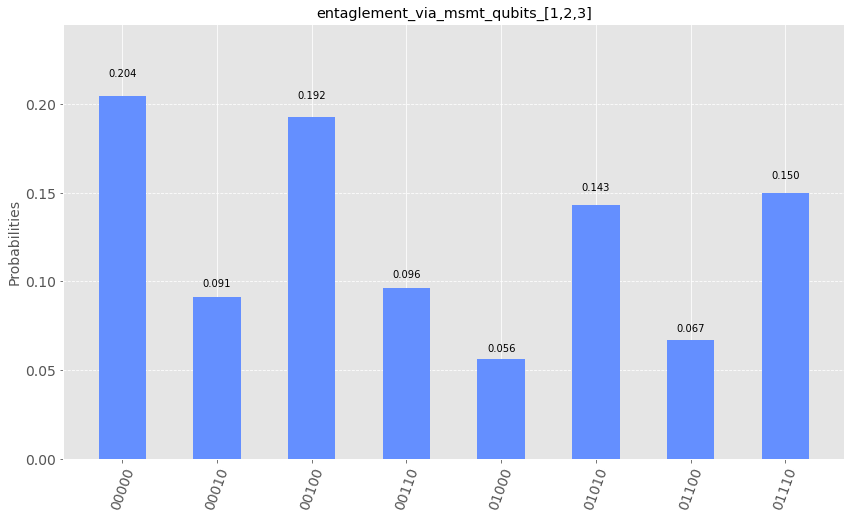

In [16]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))


In [17]:
exp_name = "entaglement_via_msmt_qubits_[1,2,3]_with_IDs"
results = get_json_data(exp_name + "_PROB.json")
results


[{'00000': 0.21929931640625,
  '00010': 0.09002685546875,
  '00100': 0.20880126953125,
  '00110': 0.09588623046875,
  '01000': 0.06439208984375,
  '01010': 0.11749267578125,
  '01100': 0.073974609375,
  '01110': 0.130126953125}]

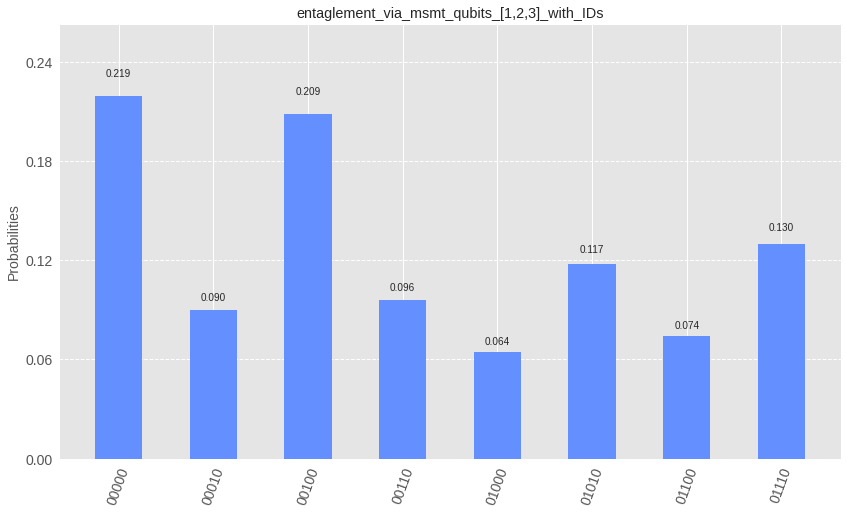

In [26]:
qvis.plot_histogram(results,
               title=exp_name,
               # filename="./data/" + exp_name + '_HIST' + '.png',
               # legend=[f"msmt {i}" for i in range(N)],
               figsize=(14,8))
